# Trajectory dataset preparation

This notebook contains some data-wrangling codes. The goal is to extract from the dataset, trajectories under suitable forms to perform FPCA and distribution learning.

# Preambles

In [1]:
%load_ext autoreload
%autoreload 2

import sys 
sys.path.append("/Users/thinhhoang/Documents/anomaly-detection-ngsim")
# sys.path.append("C:\\Users\\nxf67027\\Documents\\anomaly-detection-ngsim")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from seig import eig as eig

%matplotlib inline

# Load data from Pickled file

To restore variables, run this code:

In [2]:
import pickle

with open('prepare_trajectories.pkl', 'rb') as handle:
    pkl_obj = pickle.load(handle)
    container_t_np = pkl_obj['t']
    container_x_np = pkl_obj['x']
    container_y_np = pkl_obj['y']
    print('Data loaded from file')

num_of_trajs = container_y_np.shape[0]

Data loaded from file


# Global FPCA decomposition for Y component

In [3]:
import sklearn
import skfda

%matplotlib inline

Convert the data to appropriate type for the skfda package

In [4]:
fdgrx = skfda.FDataGrid(container_x_np, np.arange(container_x_np.shape[1]))
fdgry = skfda.FDataGrid(container_y_np, np.arange(container_y_np.shape[1]))
# here we don't use the container_t_np vector since we don't want it to mess up the unit

In [5]:
# from skfda.exploratory.visualization import plot_fpca_perturbation_graphs
from skfda.preprocessing.dim_reduction.projection import FPCA

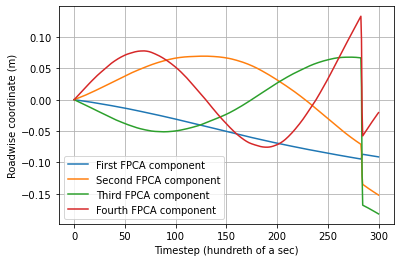

In [6]:
fpca_y = FPCA(n_components=4)
fpca_y.fit(fdgry)
fpca_y.components_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
plt.legend(['First FPCA component', 'Second FPCA component', 'Third FPCA component', 'Fourth FPCA component'])
print('')

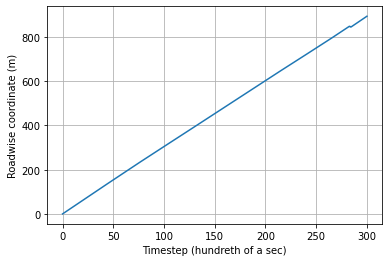

In [7]:
fpca_y.mean_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
print('')
mean_y = fpca_y.mean_.data_matrix.reshape((-1))

[0.89731514 0.07348648 0.02266406 0.00532613]


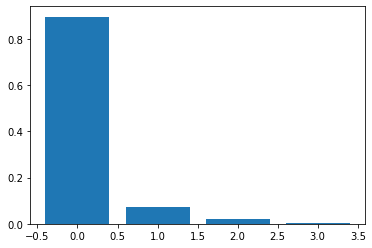

In [8]:
plt.bar(np.arange(4), fpca_y.explained_variance_ratio_)
print(fpca_y.explained_variance_ratio_)

# Global FPCA decomposition for X component

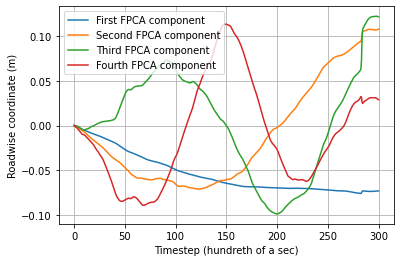

In [9]:
fpca_x = FPCA(n_components=4)
fpca_x.fit(fdgrx)
fpca_x.components_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
plt.legend(['First FPCA component', 'Second FPCA component', 'Third FPCA component', 'Fourth FPCA component'])
print('')

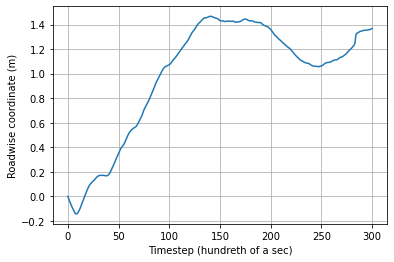

In [10]:
fpca_x.mean_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
print('')
mean_x = fpca_x.mean_.data_matrix.reshape((-1))

[0.91929363 0.04625759 0.01301754 0.00650374]


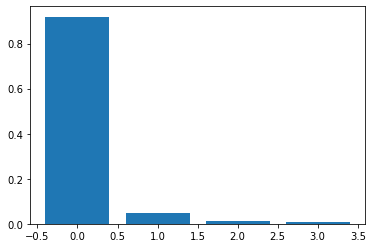

In [11]:
plt.bar(np.arange(4), fpca_x.explained_variance_ratio_)
print(fpca_x.explained_variance_ratio_)

# Zero-meaned trajectories

This might be helpful in analytically finding the basis for the trajectory (which we are suspicious that it is a Fourier basis).

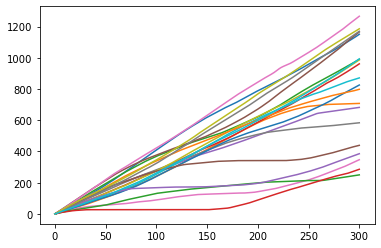

In [12]:
for i in np.random.choice(num_of_trajs, 20):
    traj_to_plot = container_y_np[i]
    plt.plot(traj_to_plot)

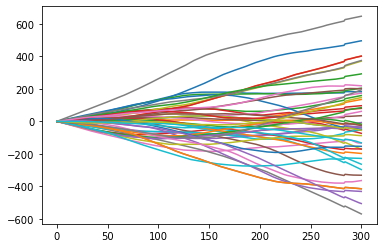

In [13]:
container_y_np_zm = container_y_np - mean_y
for i in np.random.choice(num_of_trajs, 50):
    traj_to_plot = container_y_np_zm[i]
    plt.plot(traj_to_plot)


Let's get the covariance matrix?

In [14]:
import sklearn
import skfda

%matplotlib inline

fdgry_zm = skfda.FDataGrid(container_y_np_zm, np.arange(container_y_np_zm.shape[1]))
y_covker = fdgry_zm.cov().data_matrix[0,:,:,0]

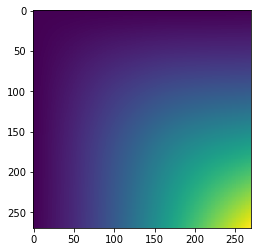

In [15]:
plt.imshow(y_covker[:270,:270], interpolation='nearest')

Diagonal elements (i.e., variances)

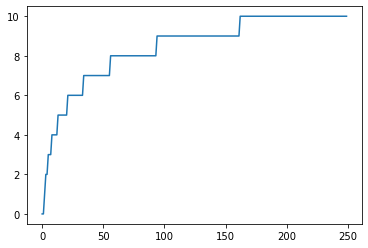

In [16]:
diag_pos = np.arange(250)
diag_elems = np.zeros_like(np.array(diag_pos))
for i, pos in enumerate(diag_pos):
    diag_elems[i] = np.log(y_covker[pos, pos]+1)
plt.plot(diag_pos, diag_elems)

Covariance between one time instance with another (i.e., the evaluation function)

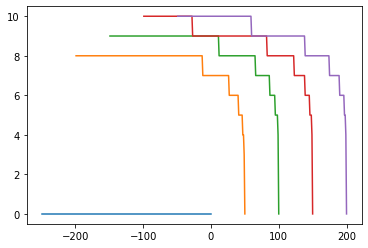

In [27]:
ego_pos = np.arange(0, 250, 50)
for ego in ego_pos:
    peer_pos = np.arange(250)
    peer_elems = np.zeros_like(np.array(peer_pos))
    peer_x = np.zeros_like(np.array(peer_pos))
    for i, pos in enumerate(peer_pos):
        peer_x[i] = ego - pos
        peer_elems[i] = np.log(y_covker[ego, pos] + 1)
    plt.plot(peer_x, peer_elems)

In [18]:
y_covker[ego,pos]

47923.422313026094